In [85]:
#pip install pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

recentPop = pd.read_csv('./data/boston pop.csv')
oldPop = pd.read_csv('./data/2015-19 census data.csv')
open_space = pd.read_csv('./data/Open_Space.csv')
#sort = pop.sort_values(by='muni_id')
locations = ['Mattapan', 'Roxbury', 'Dorchester', 'Charlestown', 'East Boston', 'Hyde Park', 'Jamaica Plain', 'Mission Hill', 
             'Roslindale', 'South Boston', 'South End', 'West Roxbury', 'Fenway', 'Longwood', 'Allston', 'Back Bay', 'Brighton', 'West End']

totPop2020 = []
whitePop2020 = []
afAmeriPop2020 = []
hisPop2020 = []
asianPop2020 = []
otherPop2020 = []

totPop2015 = []
whitePop2015 = []
afAmeriPop2015 = []
hisPop2015 = []
asianPop2015 = []
otherPop2015 = []

greenspaces = []
existing_greenways = []
in_progress_greenways = []


existingGreenway = ['Emerald', 'Southwest Coordidor', 'East Boston Greenway', 'Charles River', 'South Bay Harbor Trail', 'Neponset', 'Day Boulevard']
in_progressGreenway = ['Neponset', 'Charlesgate Greenway', 'Malcolm X Boulevard', 'Commonwealth Avenue Mall', 'Seaver Street']

# Filtering existing_greenway_data
existing_greenway_data = open_space[open_space['SITE_NAME'].str.contains('|'.join(existingGreenway), case=False) | open_space['ADDRESS'].str.contains('|'.join(existingGreenway), case=False)]

# Filtering in_progress_greenway_data
in_progress_greenway_data = open_space[open_space['SITE_NAME'].str.contains('|'.join(in_progressGreenway), case=False) | open_space['ADDRESS'].str.contains('|'.join(in_progressGreenway), case=False)]

""" 
Change the "mutli-district" entry in the DISTRICT column to Dorchester/Mattapan/Hyde Park for Neponset River Reservation 1, and change it 
to Allston/Fenway/Brighton/Back Bay/West End for Charles River Reservation
"""
def replace_district(row):
    if row['SITE_NAME'] == 'Neponset River Reservation I':
        return 'Dorchester/Mattapan/Hyde Park'
    elif row['SITE_NAME'] == 'Charles River Reservation':
        return 'Allston/Fenway/Brighton/Back Bay/West End'
    else:
        return row['DISTRICT']
    
existing_greenway_data['DISTRICT'] = existing_greenway_data.apply(replace_district, axis=1)
in_progress_greenway_data['DISTRICT'] = in_progress_greenway_data.apply(replace_district, axis=1)
open_space['DISTRICT'] = open_space.apply(replace_district, axis=1)

#filter out places that are not considered greenways
#open_space = open_space.loc[(open_space["TypeLong"] != "Cemeteries & Burying Grounds") 
                            #& (open_space["TypeLong"] != "Malls, Squares & Plazas")]

for location in locations:
    # Initialize total acres for the current location
    total_acres = 0
    greenway_acres = 0
    in_progress_greenway_acres = 0
    
    # Iterate over each row in the DataFrame
    for index, row in open_space.iterrows():
        # Check if the desired location is present in any substring after splitting by '/'
        if location in row['DISTRICT'].split('/') or location in row['DISTRICT'].split('-'):
            # Add the acres for the current row to the total acres
            total_acres += row['ACRES']
    
    for index, row in existing_greenway_data.iterrows():
        if location in row['DISTRICT'].split('/'):
            greenway_acres += row['ACRES']

    for index, row in in_progress_greenway_data.iterrows():
        if location in row['DISTRICT'].split('/'):
            in_progress_greenway_acres += row['ACRES']
    
    # Append the total acres for the current location to the greenspaces list
    greenspaces.append(total_acres)
    existing_greenways.append(greenway_acres)
    in_progress_greenways.append(in_progress_greenway_acres)

    white2020 = int(recentPop[recentPop['Area'] == location]['White alone'])
    afAmeri2020 = int(recentPop[recentPop['Area'] == location]['Black or African American alone'])
    his2020 = int(recentPop[recentPop['Area'] == location]['Hispanic or Latino'])
    asian2020 = int(recentPop[recentPop['Area'] == location]['Asian'])
    other2020 = int(recentPop[recentPop['Area'] == location]['Other Races'])

    whitePop2020.append(white2020)
    afAmeriPop2020.append(afAmeri2020)
    hisPop2020.append(his2020)
    asianPop2020.append(asian2020)
    otherPop2020.append(other2020)
    totPop2020.append(int(recentPop[recentPop['Area'] == location]['Total']))

    white2015 = int(oldPop[oldPop['Area'] == location]['White Alone'])
    afAmeri2015 = int(oldPop[oldPop['Area'] == location]['Black/African-American'])
    his2015 = int(oldPop[oldPop['Area'] == location]['Hispanic'])
    asian2015 = int(oldPop[oldPop['Area'] == location]['Asian alone'])
    other2015 = int(oldPop[oldPop['Area'] == location]['Other Races'])
    total2015 = white2015 + afAmeri2015 + his2015 + asian2015 + other2015

    whitePop2015.append(white2015)
    afAmeriPop2015.append(afAmeri2015)
    hisPop2015.append(his2015)
    asianPop2015.append(asian2015)
    otherPop2015.append(other2015)
    totPop2015.append(total2015)

focus = ['Mattapan', 'Roxbury', 'Dorchester'] 

diff = [x - y for x, y in zip(totPop2020, totPop2015)]

existing_greenways_boolean = [1 if x != 0 else 0 for x in existing_greenways]
any_greenway_boolean = [1 if (x != 0 or y != 0) else 0 for (x, y) in zip(existing_greenways, in_progress_greenways)]


""" 
I want to make a new dataframe here with the first column being the districts we have greenway data for + locations, and there are 4 features (for now): 
- greenway acres / total greenspace acres
- greenway acres / district total population
- greenway acres
- 1 if there is a greenway in that district, 0 if there isnt

Difficulites: 
- have to figure out which districts "multi-district" greenways are in... have to include in the report that the total acreage is not fully accurate in those cases, it is an overestimate.
- not all locations have corresponding population data, so we can only do the 2nd feature if there is any, and we can't compare to the displacement if there isn't either

Limitations:
- not enough data to train any kind of model on, otherwise we could have a class that is like "positive population growth" and then use that to predict for our focus locations if adding a greenspace would help
    or even how much greenspace would need to be added for it to help.
""" 
# Create dictionaries
data = {
    'locations': locations,
    'greenspace acres': greenspaces,
    'existing greenway acres': existing_greenways,
    'in progress greenway acres': in_progress_greenways,
    'presence of existing greenways': existing_greenways_boolean,
    'presence of any greenway': any_greenway_boolean,
    'pop': totPop2020,
    'displacement': diff
}

# Create DataFrame
greenway_features = pd.DataFrame(data)

# Calculate additional features
greenway_features['greenway to greenspace ratio'] = greenway_features['existing greenway acres'] / greenway_features['greenspace acres']
greenway_features['greenway to population ratio'] = greenway_features['existing greenway acres'] / greenway_features['pop']

# Set location as index
greenway_features.set_index('locations', inplace=True)

greenway_features.to_csv('./data/greenway features.csv', index=False)


C:\Users\alvis\AppData\Local\Temp/ipykernel_23580/3351708502.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_greenway_data['DISTRICT'] = existing_greenway_data.apply(replace_district, axis=1)
C:\Users\alvis\AppData\Local\Temp/ipykernel_23580/3351708502.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_progress_greenway_data['DISTRICT'] = in_progress_greenway_data.apply(replace_district, axis=1)


In [2]:
print('All Greenspace Data:', list(zip(locations, greenspaces)))
print('Existing Greenway Data:', list(zip(locations, existing_greenways)))
print('In Progress Greenspace Data:', list(zip(locations, in_progress_greenways)))
print('Presence of Existing Greenways:', list(zip(locations, existing_greenways_boolean)))
print('Presence of Existing or In-Progress Greenways:', list(zip(locations, any_greenway_boolean)))
print('Location Populations:', list(zip(locations, totPop2020)))
print('Difference in Population:', list(zip(locations, diff)))


All Greenspace Data: [('Mattapan', 418.60203545999997), ('Roxbury', 568.7538756499999), ('Dorchester', 589.7462752099999), ('Charlestown', 65.91124654), ('East Boston', 255.83183062), ('Hyde Park', 934.32259027), ('Jamaica Plain', 743.95578997), ('Mission Hill', 27.20438636), ('Roslindale', 209.7417969), ('South Boston', 208.25169892000002), ('South End', 19.979065499999997), ('West Roxbury', 987.8139695500001), ('Fenway', 290.61555541), ('Longwood', 118.71911351), ('Allston', 419.44953785000007), ('Back Bay', 256.47553501000004), ('Brighton', 419.44953785000007), ('West End', 171.8964419)]
Existing Greenway Data: [('Mattapan', 183.50152012), ('Roxbury', 0), ('Dorchester', 183.50152012), ('Charlestown', 0), ('East Boston', 4.74406398), ('Hyde Park', 189.04167408), ('Jamaica Plain', 0), ('Mission Hill', 0), ('Roslindale', 0), ('South Boston', 16.85070443), ('South End', 0), ('West Roxbury', 0), ('Fenway', 241.99672544000003), ('Longwood', 70.10028354), ('Allston', 171.8964419), ('Back B

In [3]:
print('Greenway Features:')
greenway_features.head(18)

Greenway Features:


,greenspace acres,existing greenway acres,in progress greenway acres,presence of existing greenways,presence of any greenway,pop,displacement,greenway to greenspace ratio,greenway to population ratio
locations,,,,,,,,,
Mattapan,418.602035,183.501520,183.501520,1,1,23840,-2819,0.438367,0.007697
Roxbury,568.753876,0.000000,401.791484,0,1,54533,372,0.000000,0.000000
Dorchester,589.746275,183.501520,184.049747,1,1,122191,-4718,0.311153,0.001502
Charlestown,65.911247,0.000000,0.000000,0,0,19120,-770,0.000000,0.000000
East Boston,255.831831,4.744064,0.000000,1,1,43066,-4197,0.018544,0.000110
Hyde Park,934.322590,189.041674,189.041674,1,1,34172,-4752,0.202330,0.005532
Jamaica Plain,743.955790,0.000000,0.000000,0,0,40015,-852,0.000000,0.000000
Mission Hill,27.204386,0.000000,0.000000,0,0,17518,132,0.000000,0.000000
Roslindale,209.741797,0.000000,0.000000,0,0,29586,-435,0.000000,0.000000


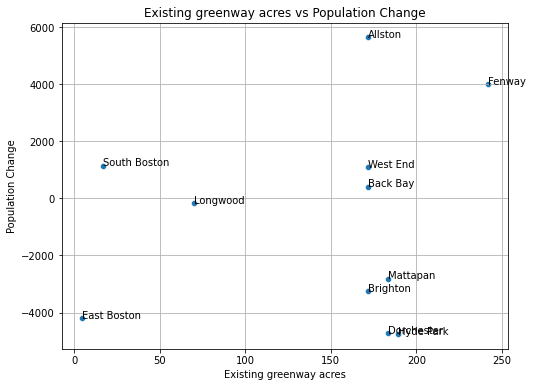

Correlation Coefficient: 0.159714633731855


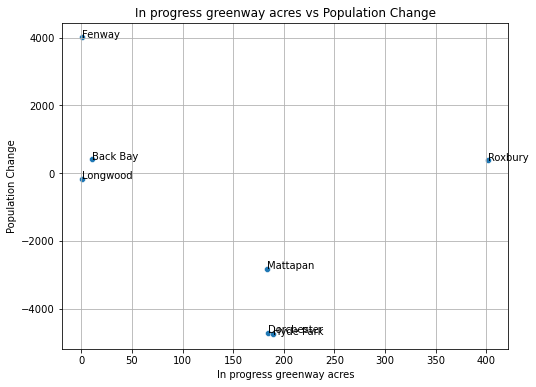

Correlation Coefficient: -0.37780046836212067


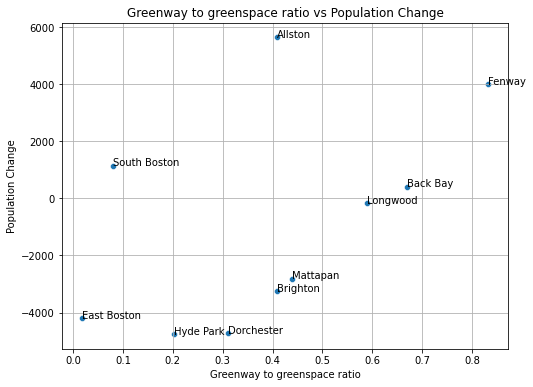

Correlation Coefficient: 0.5029970303739275


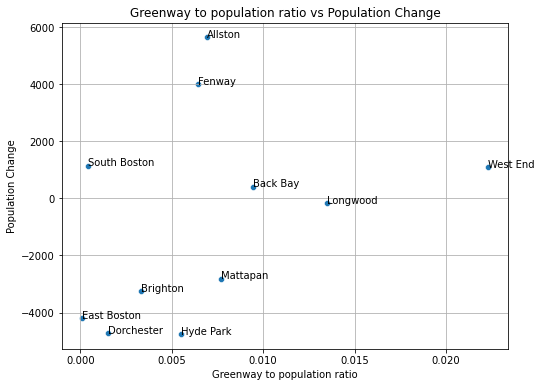

Correlation Coefficient: 0.3401616952852244


In [4]:
features = ['existing greenway acres', 'in progress greenway acres', 'greenway to greenspace ratio', 'greenway to population ratio']
for feature in features:
    filtered_df = greenway_features[(greenway_features[feature] != 0) & (greenway_features[feature] != 1) & (greenway_features[feature] != np.inf)]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=filtered_df, x=feature, y='displacement')
    plt.title(f'{feature.capitalize()} vs Population Change')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Population Change')
    plt.grid(True)
    for i in range(len(filtered_df)):
        plt.text(filtered_df.iloc[i][feature], filtered_df.iloc[i]['displacement'], filtered_df.index[i])
    plt.show()
    correlation_coefficient, _ = pearsonr(filtered_df[feature], filtered_df['displacement'])
    print("Correlation Coefficient: " + str(correlation_coefficient))

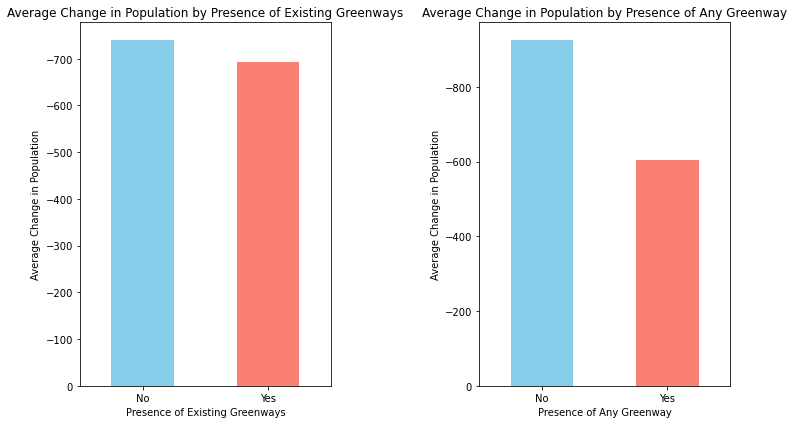

In [5]:
# Calculate average displacement for each group based on boolean features
avg_displacement_by_existing_greenway = greenway_features.groupby('presence of existing greenways')['displacement'].mean()
avg_displacement_by_any_greenway = greenway_features.groupby('presence of any greenway')['displacement'].mean()

# Create bar plots
plt.figure(figsize=(10, 6))

# Bar plot for presence of existing greenways
plt.subplot(1, 2, 1)
avg_displacement_by_existing_greenway.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Change in Population by Presence of Existing Greenways')
plt.xlabel('Presence of Existing Greenways')
plt.ylabel('Average Change in Population')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.gca().invert_yaxis() 

# Bar plot for presence of any greenway
plt.subplot(1, 2, 2)
avg_displacement_by_any_greenway.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Change in Population by Presence of Any Greenway')
plt.xlabel('Presence of Any Greenway')
plt.ylabel('Average Change in Population')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.gca().invert_yaxis() 

plt.tight_layout(w_pad=10)
plt.show()

In [6]:
print("Existing Greenway Data:")
existing_greenway_data.head(10)

Existing Greenway Data:


,OBJECTID,SITE_NAME,OWNERSHIP,PROTECTION,TYPECODE,DISTRICT,ACRES,ADDRESS,ZonAgg,TypeLong,...,AgncyJuris,PARK_ID,REGION,OS_ID,F_100ftRule,ZipCode,ParcelNumber,YearAcquired,Shape_Length,Shape_Area
74,75,East Boston Greenway,City of Boston,A97/WPA,2,East Boston,3.501793,44 Marginal Street,Residential District,"Parkways, Reservations & Beaches",...,BPRD,97.0,PARK_Maintenance_Region 1,97,YES,02128,"0103918002,0103920055,0105346060,0103918055,01...",0,0.017335,1.548830e-06
248,249,Neponset Valley Parkway,Commonwealth of Massachusetts,A97,2,Hyde Park,5.540154,,Residential District,"Parkways, Reservations & Beaches",...,NaN,NaN,INFO_Reallocation From Dept,3047,YES,02136,NaN,0,0.027450,2.445568e-06
346,347,Back Bay Fens,City of Boston,A97/LWCF/UPARR/NRHP/WPA/Ch91,3,Fenway/Longwood,70.100284,100 Park Drive (Clemente Field House) 125 The ...,Residential District,"Parks, Playgrounds & Athletic Fields",...,BPRD,13.0,PARK_Maintenance_Region 3,13,YES,"02115, 02215","0504175001,0401705000,0504175000",1877,0.073758,3.099191e-05
475,476,Neponset River Reservation I,Commonwealth of Massachusetts,A97/WPA/ACEC,2,Dorchester/Mattapan/Hyde Park,183.501520,,Open Space District,"Parkways, Reservations & Beaches",...,DCR,NaN,INFO_Reallocation From Dept,3101,YES,"02126, 02021, 02124, 02136",NaN,0,0.281022,8.101993e-05
479,480,Charles River Reservation,Commonwealth of Massachusetts,A97/Ch91/WPA,2,Allston/Fenway/Brighton/Back Bay/West End,171.896442,,Open Space District,"Parkways, Reservations & Beaches",...,DCR,NaN,INFO_Reallocation From Dept,3105,YES,"02134, 02115, 02163, 02135, 02114, 02108, 0211...",NaN,0,0.560472,7.602001e-05
507,508,Columbia Road/Day Boulevard,Commonwealth of Massachusetts,A97,2,South Boston,16.850704,,Open Space District,"Parkways, Reservations & Beaches",...,DCR,NaN,INFO_Reallocation From Dept,3108,YES,"02125, 02127",NaN,0,0.154081,7.448238e-06
522,523,East Boston Greenway Extension,Massport,NaN,3,East Boston,1.242271,,Multiple Districts,"Parks, Playgrounds & Athletic Fields",...,Massport,NaN,INFO_Reallocation from Dept,7269,YES,02128,NaN,0,0.022499,5.491745e-07


In [7]:
print("\nIn Progress Greenway Data:")
in_progress_greenway_data.head(10)


In Progress Greenway Data:


,OBJECTID,SITE_NAME,OWNERSHIP,PROTECTION,TYPECODE,DISTRICT,ACRES,ADDRESS,ZonAgg,TypeLong,...,AgncyJuris,PARK_ID,REGION,OS_ID,F_100ftRule,ZipCode,ParcelNumber,YearAcquired,Shape_Length,Shape_Area
77,78,Commonwealth Avenue Mall II,City of Boston,A97/LWCF,1,Fenway/Longwood,0.971006,Commonwealth Ave btwn Charlesgate West & Kenmo...,Residential District,"Malls, Squares & Plazas",...,BPRD,63.0,PARK_Maintenance_Region 1,63,YES,02215,0503893500,0,0.004318,4.293344e-07
146,147,Puddingstone Park,City of Boston,A97,3,Dorchester,0.548227,330 Seaver Street,Open Space District,"Parks, Playgrounds & Athletic Fields",...,BPRD,247.0,PARK_Maintenance_Region 2,247,YES,02121,"1400829000,1400828000,1400830000,1400831000",0,0.002131,2.422352e-07
149,150,Madison Park H.S. Athletic Fields,City of Boston,NaN,3,Roxbury,9.606467,55 Malcolm X Boulevard,Institutional District,"Parks, Playgrounds & Athletic Fields",...,BPS,183.0,PARK_Maintenance_Region 5,183,YES,02120,0902980000,0,0.008396,4.246450e-06
248,249,Neponset Valley Parkway,Commonwealth of Massachusetts,A97,2,Hyde Park,5.540154,,Residential District,"Parkways, Reservations & Beaches",...,NaN,NaN,INFO_Reallocation From Dept,3047,YES,02136,NaN,0,0.027450,2.445568e-06
362,363,Commonwealth Avenue Mall I,City of Boston,A97/LWCF/NRHP,1,Back Bay/Beacon Hill,10.871183,Commonwealth Ave btwn Arlington St & Charlesga...,Residential District,"Malls, Squares & Plazas",...,BPRD,62.0,PARK_Maintenance_Region 1,62,YES,"02115, 02116, 02215","0503371500,0503575500,0503817500,0502824500,05...",0,0.047953,4.806911e-06
467,468,Franklin Park,City of Boston,A97/WPA/NRHP,3,Roxbury,392.185016,25 Pierpont Road \r\n155 Seaver Street (Tiffan...,Open Space District,"Parks, Playgrounds & Athletic Fields",...,BPRD,124.0,PARK_Maintenance_Region 3,124,YES,"02130, 02121","1203487001,1203486000",1883,0.117780,1.732797e-04
475,476,Neponset River Reservation I,Commonwealth of Massachusetts,A97/WPA/ACEC,2,Dorchester/Mattapan/Hyde Park,183.501520,,Open Space District,"Parkways, Reservations & Beaches",...,DCR,NaN,INFO_Reallocation From Dept,3101,YES,"02126, 02021, 02124, 02136",NaN,0,0.281022,8.101993e-05


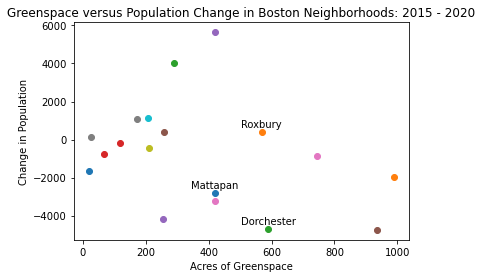

Correlation Coefficient: -0.33107555769289804


In [8]:
for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus Population Change in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

The graph depicts all populations and compares the change in population with the acres of greenspace. From the graph, we can infer that there is a negative correlation between the two, but this does not mean there is causation.

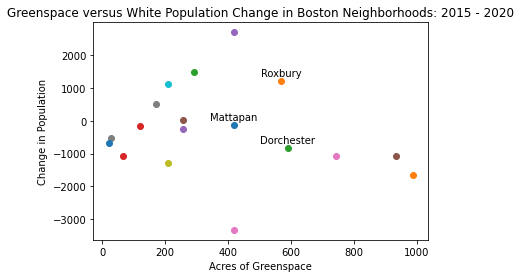

Correlation Coefficient: -0.2065201271342214


In [9]:
diff = [x - y for x, y in zip(whitePop2020, whitePop2015)]

for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus White Population Change in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

For white populations, little to no correlation can be seen. 

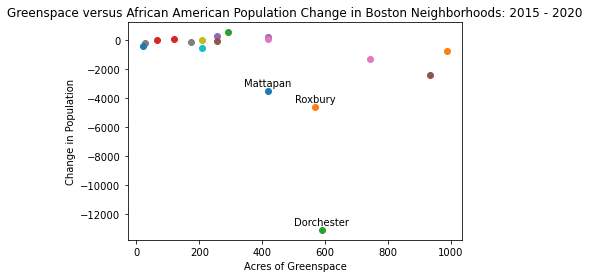

Correlation Coefficient: -0.3714181378833382


In [10]:
diff = [x - y for x, y in zip(afAmeriPop2020, afAmeriPop2015)]

for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus African American Population Change in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

In African American populations, there is a slight negative correlation. Dorchester is the only real big outlier, which could be impacting the correlation coefficient.

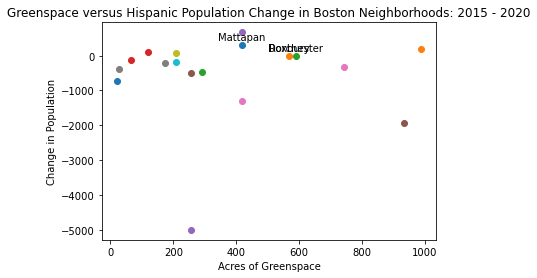

Correlation Coefficient: 0.005424759086325101


In [11]:
diff = [x - y for x, y in zip(hisPop2020, hisPop2015)]

for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus Hispanic Population Change in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

Hispanic populations also show little to no correlation.

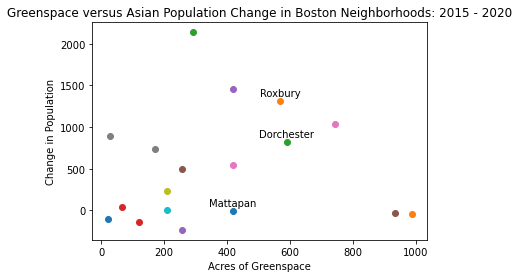

Correlation Coefficient: 0.06864547604930044


In [12]:
diff = [x - y for x, y in zip(asianPop2020, asianPop2015)]

for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
        
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus Asian Population Change in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

In Asian populations, a slight positive correlation can be seen between change in population and greenspace.

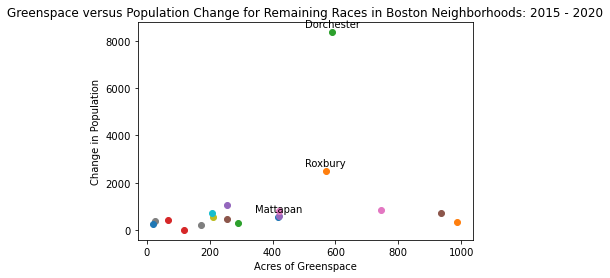

Correlation Coefficient: 0.2659804436494482


In [13]:
diff = [x - y for x, y in zip(otherPop2020, otherPop2015)]

for i, location in enumerate(locations):
    plt.scatter(greenspaces[i], diff[i], label=location)

    if location in focus:
        plt.annotate(location, (greenspaces[i], diff[i]), textcoords="offset points", xytext=(0, 5), ha='center')
        
plt.ylabel('Change in Population')
plt.xlabel('Acres of Greenspace')
plt.title('Greenspace versus Population Change for Remaining Races in Boston Neighborhoods: 2015 - 2020')
plt.show()

correlation_coefficient, _ = pearsonr(greenspaces, diff)
print("Correlation Coefficient: " + str(correlation_coefficient))

For all remaning races, a slight positive correlation can be found. However, there are outliers such as Dorchester and maybe Roxbury. Based on these early insights on the data, we again cannot confidently make claims on if there is causation between the change in population and greenspace. Our data on the different races shows that the correlation varies from race to race. In addition, common outliers can be seen: Roxbury and Dorchester. While we continue to work with and incorporate new data, we will keep an eye on these regions to see if they are continuously outliers.